In [106]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

In [107]:
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

## Process labelling results 

In [108]:
ordered_verts = ['T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4']

In [185]:
root_dir = '/data/PAB_data/vert_labelling/'
filename = 'labeller_preds.npz'

pred_dict = {}
gt_dict = {}
fold_dict = {}
img_dict = {}
heatmap_dict = {}
coords_dict = {}
labels_dict = {}
for root, dirs, files in os.walk(root_dir):
    if filename in files:
        fold = root.split('/')[-1]
        print(fold)
        
        # Collect targets
        tgt_path = os.path.join(root, 'targets/coordinates/')
        for file in os.listdir(tgt_path):
            name = file.split('.')[0]
            gt_dict[name] = pd.read_csv(os.path.join(tgt_path, file))
        # Collect input image
        img_path = os.path.join(root, 'slices')
        for file in os.listdir(img_path):
            name = file.split('.')[0]
            img_dict[name] = np.load(os.path.join(img_path, file))
        # Collect predictions
        pred = np.load(os.path.join(root, filename))
        for id_, mask, coords, heatmaps, labels in zip(pred['ids'], pred['masks'], 
                                                    pred['coords'], pred['heatmaps'], pred['labels']):
            pred_dict[id_] = mask
            fold_dict[id_] = fold
            coords_dict[id_] = coords
            heatmap_dict[id_] = heatmaps
            labels_dict[id_] = labels
print(len(pred_dict.keys()), len(list(gt_dict.keys())))

q1
100 100


In [186]:
ids = list(pred_dict.keys())

## Check preds

In [187]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [188]:
@interact
def plot_preds(name=ids):
    label_threshold = 0.8
    idx = ids.index(name)
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))
#     ax[0].axis('off')
#     ax[1].axis('off')
    coords = coords_dict[name]
    gt_coords = gt_dict[name]
    labels = sigmoid(labels_dict[name])
    print(labels)
    
    img = img_dict[name][..., 1]
    print(img.max(), img.min())
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(img, cmap='gray')
    
    # Plot ground-truth
    for i, vert in enumerate(ordered_verts):
        if vert not in pd.unique(gt_coords['Level']): continue
        tmp =  gt_coords.loc[gt_coords['Level'] == vert].values[0]
        vert, x, y = tmp
        ax[0].scatter(x, y, marker='+', c='y', s=15)
        ax[0].text(x, y, vert, c='y', size=15)
    
    # Plot predictions
    for i, vert in enumerate(ordered_verts):
        if labels[i] >= label_threshold:
            y, x = coords[i]
            ax[1].scatter(x, y, marker='+', c='y', s=15)
            ax[1].text(x, y, vert, c='y', size=15)
    
    plt.subplots_adjust(wspace=0)

interactive(children=(Dropdown(description='name', options=('fr_511_LS_Sag', '03_06_2014_399_LS_Sag', 'fr_534_…

## CDFs

In [189]:
def calc_error(name):
    coords = coords_dict[name]
    gt_coords = gt_dict[name]
    
    dist_dict = {}
    for row in gt_coords.iterrows():
        level, x, y = row[1]
        idx = ordered_verts.index(level)
        pred_x, pred_y = coords[idx][::-1]
        #dist = np.sqrt((pred_x-x)**2 + (pred_y-y)**2)
        dist = y-pred_y
        dist_dict[level] = dist*1.25 #Convert to mm
    return pd.DataFrame(dist_dict, index=['Distance'])

In [190]:
all_df = pd.DataFrame(columns=['Level', 'Distance'])
for name in ids:
    df = calc_error(name)
    df = pd.melt(df, var_name='Level', value_name='Distance')
    all_df = all_df.append(df, ignore_index=True)
display(all_df)

,Level,Distance
0,T10,26.872084
1,T11,34.143327
2,T12,33.120154
3,L1,28.563564
4,L2,23.390164
...,...,...
745,T12,-8.605208
746,L1,-11.243884
747,L2,-11.592156
748,L3,-11.965109


In [191]:
hist_df = all_df.groupby(by='Level').median().reindex(ordered_verts)

In [192]:
hist_df

,Distance
Level,
T4,3.890153
T5,8.579377
T6,8.806529
T7,10.797145
T8,5.080239
T9,-0.165055
T10,4.669110
T11,3.075767
T12,1.484607


<AxesSubplot:xlabel='Distance', ylabel='Level'>

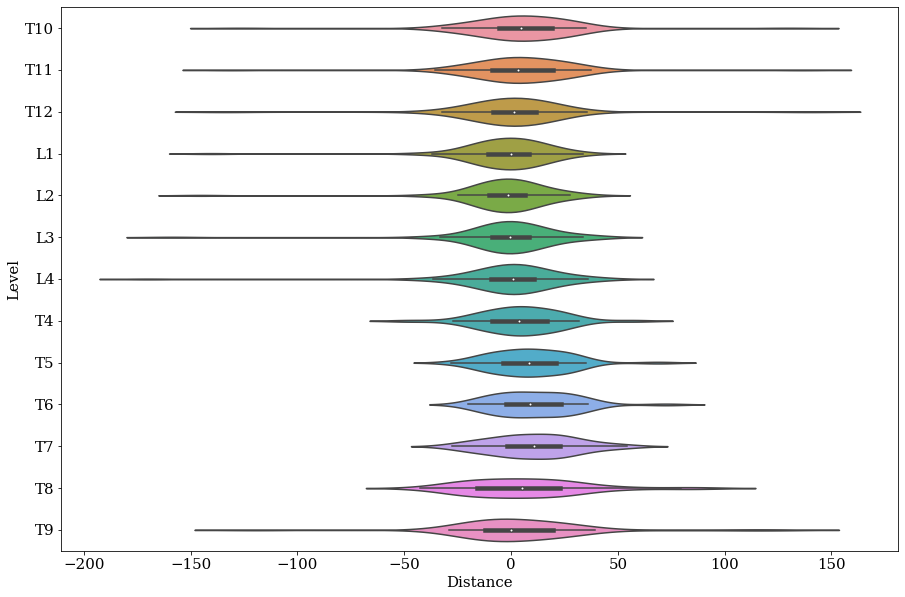

In [193]:
plt.subplots(1, 1, figsize=(15, 10))
sns.violinplot(data=all_df, y='Level',x='Distance')#, order=ordered_verts)

In [194]:
all_df['Within Limit'] = all_df['Distance'] <= 20
count_df = all_df.groupby('Level')['Within Limit'].agg('sum')/all_df.groupby('Level')['Within Limit'].agg('count')
count_df = count_df.reindex(ordered_verts)

In [195]:
type(count_df)

pandas.core.series.Series

<AxesSubplot:xlabel='Level', ylabel='Within Limit'>

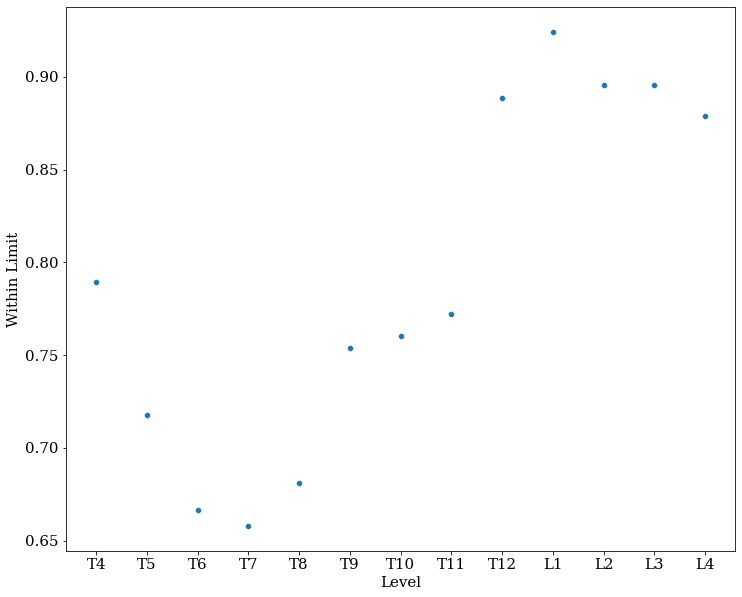

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.scatterplot(data=count_df)

In [197]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

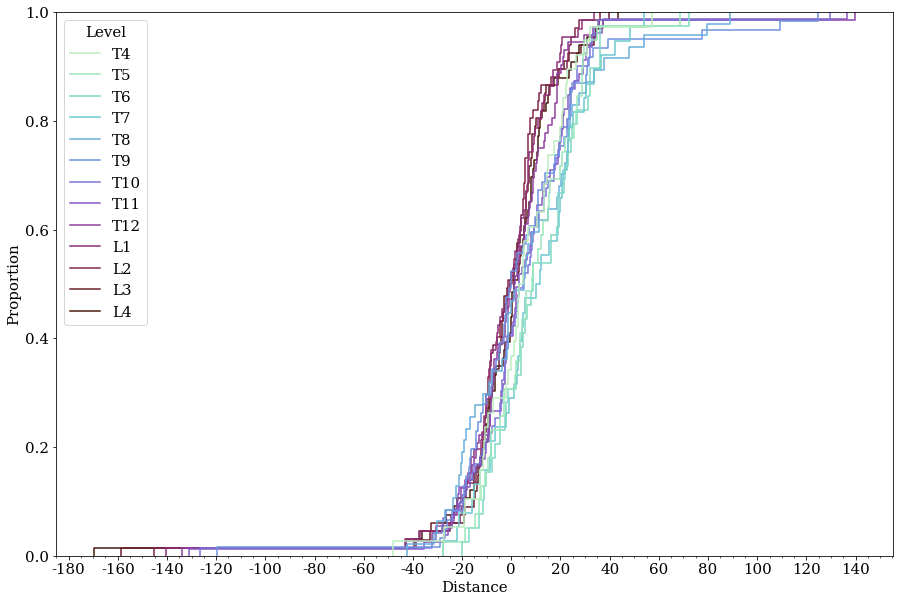

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cmap = sns.cubehelix_palette(start=1.5, rot=-1, hue=1.4, gamma=1.0, as_cmap=False, n_colors=13)
sns.ecdfplot(data=all_df, x='Distance', hue='Level', hue_order=ordered_verts, palette=cmap)

ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_major_formatter('{x:.0f}')

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(5))

In [206]:
all_df

,Level,Distance,Within Limit
0,T10,26.872084,False
1,T11,34.143327,False
2,T12,33.120154,False
3,L1,28.563564,False
4,L2,23.390164,False
...,...,...,...
745,T12,-8.605208,True
746,L1,-11.243884,True
747,L2,-11.592156,True
748,L3,-11.965109,True


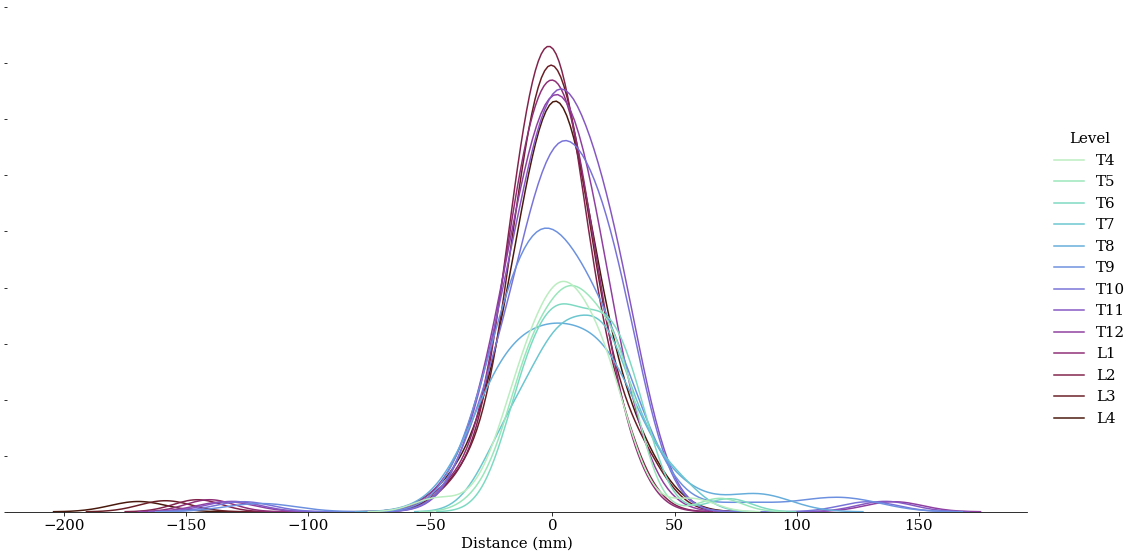

In [220]:
g = sns.displot(all_df, x='Distance', hue='Level', hue_order=ordered_verts, palette=cmap, kind='kde', height=8, aspect=2)
g.set_yticklabels([])
g.set_axis_labels("Distance (mm)", "")
g.despine(left=True)